In [38]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from Database import Database
import matplotlib.pyplot as plt
import pickle

In [39]:
f = open('configs.json')
configs = json.load(f)
f.close()

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

db = Database(configs)
df = db.fetch_average_price(fuel_type="E10", interval='D')


df['timestamp'] = pd.to_datetime(df['timestamp'])


df_pivot = df.pivot_table(index='timestamp', columns='station_code', values='price')
# df_pivot.to_csv('pivot'+'.csv')
print(df_pivot.head())
print("================================")


# Missing values, change to nearby station data later
df_pivot.fillna(method='ffill', inplace=True)
df_pivot.fillna(method='bfill', inplace=True)


scaler = MinMaxScaler()
df_pivot_scaled = scaler.fit_transform(df_pivot)
df_pivot_scaled = pd.DataFrame(df_pivot_scaled, index=df_pivot.index, columns=df_pivot.columns)
print(df_pivot_scaled.head())



seq_length = 14
print("len df pvt scaled: ", len(df_pivot_scaled))
X, y = [], []
for i in range(len(df_pivot_scaled) - seq_length):
    X.append(df_pivot_scaled.iloc[i:i+seq_length].values)
    y.append(df_pivot_scaled.iloc[i+seq_length].values)

X = np.array(X)
y = np.array(y)

y_copy = scaler.inverse_transform(y)
daily_avg_actual = y_copy.mean(axis=1)
print(daily_avg_actual)

print(f"X shape: {X.shape}, y shape: {y.shape}")

n_features = 1

model = Sequential()
model.add(InputLayer((seq_length, 1470)))
model.add(LSTM(2048, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(2048))
model.add(Dense(1470, activation='relu'))
model.add(Dense(1470, activation='linear'))

optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
# model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[reduce_lr])

model.summary()

station_code   1  10    100  1005   1006  1008    101  1010   1014    102  \
timestamp                                                                   
2024-07-03   NaN NaN    NaN   NaN    NaN   NaN  179.9   NaN    NaN  179.9   
2024-07-04   NaN NaN  179.9   NaN    NaN   NaN    NaN   NaN  181.7    NaN   
2024-07-05   NaN NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN   
2024-07-06   NaN NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN   
2024-07-07   NaN NaN    NaN   NaN  172.9   NaN    NaN   NaN    NaN    NaN   

station_code  ...    972  974  975    976    982  983    984    985  99  999  
timestamp     ...                                                             
2024-07-03    ...    NaN  NaN  NaN  177.7    NaN  NaN    NaN  180.9 NaN  NaN  
2024-07-04    ...    NaN  NaN  NaN    NaN  175.4  NaN  175.4    NaN NaN  NaN  
2024-07-05    ...  182.5  NaN  NaN  173.8    NaN  NaN    NaN    NaN NaN  NaN  
2024-07-06    ...    NaN  NaN  NaN  173.9    NaN  NaN    NaN    N

C:\Users\User\AppData\Local\Temp\ipykernel_24380\3336836300.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot.fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24380\3336836300.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot.fillna(method='bfill', inplace=True)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.4369 - val_loss: 0.0620 - learning_rate: 5.0000e-05
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.4132 - val_loss: 0.0608 - learning_rate: 5.0000e-05
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.3543 - val_loss: 0.0740 - learning_rate: 5.0000e-05
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.3075 - val_loss: 0.1141 - learning_rate: 5.0000e-05
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2711 - val_loss: 0.1565 - learning_rate: 5.0000e-05
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2422 - val_loss: 0.1666 - learning_rate: 5.0000e-05
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2004 - val_loss: 0.1620 - learning_rate: 5.0000e-05
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1843 - val_loss: 0.1639 - learning_rate: 2.5000e-05
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.1639 - val_loss: 0.1627 - learning_rate: 2.5000e-05
Epoch 10/1

x shape:  (34, 7, 1470)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
[194.8685  195.00845 195.18124 195.40051 195.67143]
DatetimeIndex(['2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13',
               '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17',
               '2024-07-18', '2024-07-19', '2024-07-20', '2024-07-21',
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
               '2024-08-03', '2024-08-04', '2024-08-05', '2024-08-06',
               '2024-08-07', '2024-08-08', '2024-08-09', '2024-08-10',
               '2024-08-11', '2024-08-12'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
Date Range: 2024-07-03 00:00:00 to 2024-08-12 00:00:00


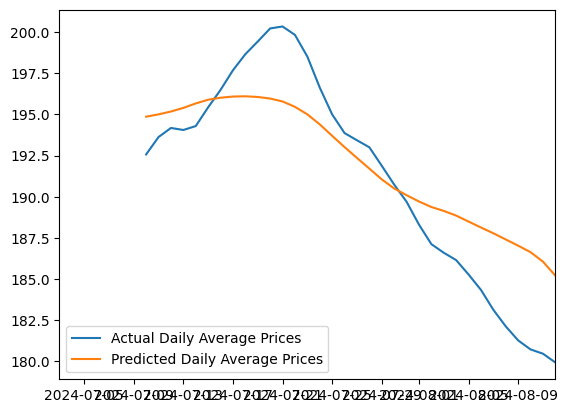

Predictions: [194.8685  195.00845 195.18124 195.40051 195.67143]
Actual Values: [192.57515873 193.63160998 194.18197279 194.05950113 194.29657823]
Is null count: station_code
1       0
10      0
100     0
1005    0
1006    0
       ..
983     0
984     0
985     0
99      0
999     0
Length: 1470, dtype: int64


In [37]:
print("x shape: ", X.shape)
predictions = model.predict(X)

predictions = scaler.inverse_transform(predictions)
y = scaler.inverse_transform(y)

daily_avg_predictions = predictions.mean(axis=1)

print(daily_avg_predictions[:5])
print(df_pivot.index[seq_length:])

# pred = pd.DataFrame(daily_avg_predictions)
# pred.to_csv("pred.csv")

# act = pd.DataFrame(daily_avg_actual)
# act.to_csv("act.csv")


print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
plt.xlim(df_pivot.index.min(), df_pivot.index.max())

plt.plot(df_pivot.index[seq_length:], daily_avg_actual, label='Actual Daily Average Prices')
plt.plot(df_pivot.index[seq_length:], daily_avg_predictions, label='Predicted Daily Average Prices')
plt.legend()
plt.show()

print("Predictions:", daily_avg_predictions[:5])
print("Actual Values:", daily_avg_actual[:5])
print("Is null count:", df_pivot.isnull().sum())

